Jelle, July 2016

This example shows how to fit Qy to nuclear recoil calibration data. 

I simulate data from a hypothetical low-energy nuclear recoil calibration using the default Qy curve (a Bezrukov model used in the S2-only paper). Next, I parametrize Qy with a simple line-segment function, then use MCMC (via the emcee package) to find the best-fit Qy curve.

In [21]:
from copy import deepcopy

import numpy as np
from tqdm import tqdm
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from wimpy.likelihood import LogLikelihood
from wimpy.model import Model
from wimpy.inference import make_objective
from wimpy.utils import InterpolateAndExtrapolate1D

from wimpy.xenon.base_model import config, nr_ignore_settings
from wimpy.xenon.XENONSource import XENONSource

import emcee
import corner

# Create 'true' data

Let's consider a hypothetical nuclear recoil calibration, from which we want to extract Qy. Say the energy spectrum has this shape:

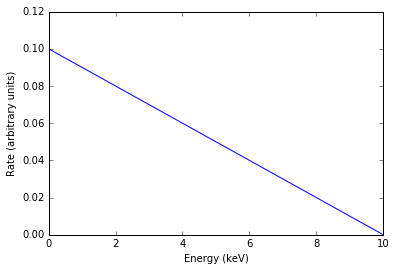

In [23]:
es = np.linspace(0, 10, 1000)
rates = np.clip((1 - es / 10)*0.1, 0, float('inf'))
plt.plot(es, rates)
plt.xlabel('Energy (keV)')
plt.ylabel('Rate (arbitrary units)')

e_spectrum_filename = 'qyfitexample_spectrum.csv'
pd.DataFrame(np.vstack((es, rates)).T, columns=['kev', 'events_per_day']).to_csv(e_spectrum_filename)

Let's use a 1d space, since we're only interested in S2 quantities, and S1 offers very little additional information about the energy. (S1 is a much poorer energy estimator than S2)

In [30]:
config['sources'] = []
config.update(dict(
    sources = [{
        'energy_distribution': e_spectrum_filename,
        'recoil_type': 'nr',
        'name': 'mysource',
        'ignore_settings': [],
        'n_events_for_pdf': 1e6}],
    require_s1=True,
    s1_area_threshold=0,
    pdf_sampling_batch_size=1e5,
    analysis_space=(('cs2', tuple(np.linspace(0, 2000, 50))),)
))
true_m = Model(config)

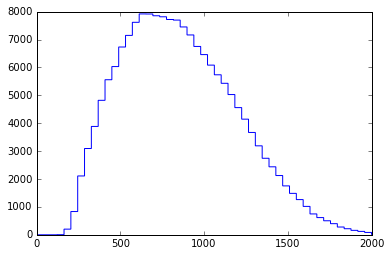

In [31]:
d = true_m.simulate()
plt.hist(d['cs2'], np.linspace(0, 2000, 50), histtype='step');

Since this is Monte Carlo data, we can examine how many events we actually see at each energy. We can't use this in the analysis of course, but it is useful to figure out which energy regions we are sensitive to.

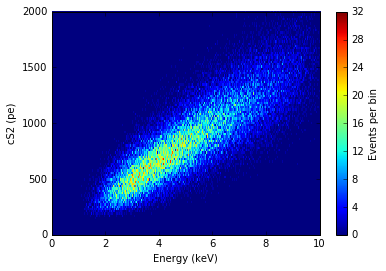

In [32]:
plt.hist2d(d['energy'], d['cs2'], bins=(es, np.linspace(0, 2000, 100)));
plt.colorbar(label='Events per bin')
plt.xlabel("Energy (keV)")
plt.ylabel("cS2 (pe)")

As you can see, things start to get poor below 3 keV and we have absolutely no sensivity below 2 keV. There are a handful events there, but they have similar S2s as events from 3 keV. The most important cause of this is the S1 requirement: at these low energies, it is unlikely an S1 will be produced.

# QY fitting model

We must have some functional model of Qy to fit it. I'm going to choose a simple connect-the-dots line since it is a very visual. I'll choose for points between which the Qy can vary, with each of them initially at 5.8 e-/keV.

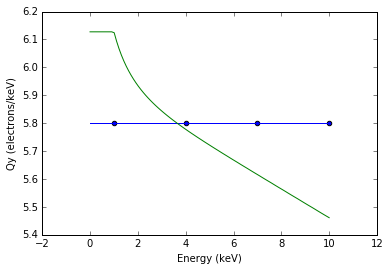

In [74]:
es_anchors = [1, 4, 7, 10]
es = np.linspace(0, 10, 100)
guess = np.array([5.8] * len(es_anchors))

def plot_qy(qy_shifts=tuple([0] * len(guess)), errors=None, **kwargs):
    qy_shifts = np.asarray(qy_shifts)
    qy_anchors = guess + qy_shifts
    y = np.interp(es, es_anchors, qy_anchors)
    plt.plot(es, y, **{k: v for k, v in kwargs.items() if k != 'label'})
    if errors is not None:
        plt.errorbar(es_anchors, qy_anchors, yerr=errors, **kwargs)
    else:
        plt.scatter(es_anchors, qy_anchors, marker='o', **kwargs)

def plot_true_qy():
    plt.plot(es, true_m.sources[0].yield_at(es, 'nr', 'electron'), label='True')
    plt.xlabel("Energy (keV)")
    plt.ylabel("Qy (electrons/keV)")
    
plot_qy()
plot_true_qy()

To construct the likelihood function, we need to let it use this Qy. Normally you input Qy via a csv file, but in this case, that would not work: we want to vary each of the points as an independent setting / parameter. Hence we need to change the Source class to construct the Qy itself. This isn't nearly as hard as it sounds:

In [52]:
class VariableQySource(XENONSource):
    
     def setup(self):
        super().setup()
        
        # Get the Qy values from the config
        qy_points = np.array([self.model.config['qy_shift_%d' % i] 
                              for i in range(len(guess))], dtype=np.float)
        qy_points += guess
        
        # Note XENONSource expects the qy function to take log(energy) arguments:
        self.yield_functions['qy'] = InterpolateAndExtrapolate1D(np.log10(es_anchors), qy_points)

        
# Create a new config, in which we tell the model to use this source class rather than XENONSource
conf2 = deepcopy(config)
conf2['default_source_class'] = VariableQySource
for i in range(len(guess_qy)):
    conf2['qy_shift_%d' % i] = 0
    
# Construct the model, add the QY shifts as shape parameters
lf = LogLikelihood(conf2)
for i in range(len(guess)):
    lf.add_shape_parameter('qy_shift_%d' % i, (-0.5, 0, 0.5))
lf.prepare()

Let's check that the models are suffiently distinguishable:

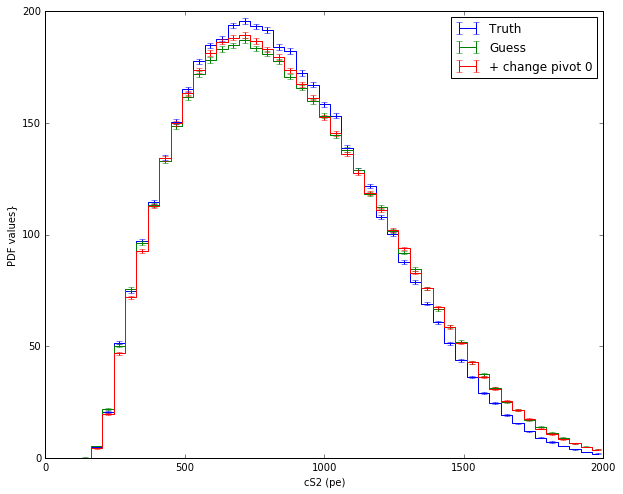

In [59]:
def plot_pdf(m, **kwargs):
    s = m.sources[0]
    scale = m.expected_events()[0]
    plt.errorbar(s.pdf_histogram.bin_centers(0),
                 s.pdf_histogram.histogram * scale,
                 yerr=s.pdf_errors.histogram* scale, linestyle='steps-mid', **kwargs)
    plt.xlabel('cS2 (pe)')
    plt.ylabel('Expected events / bin')
    
plt.figure(figsize=(10, 8))
plot_pdf(true_m, label='Truth')
c = [0] * len(guess_qy)
m1 = lf.anchor_models[tuple(c)]
c[0] = +0.5
m2 = lf.anchor_models[tuple(c)]
plot_pdf(m1, label='Guess')
plot_pdf(m2, label='+ change pivot 0')
plt.legend(loc='upper right')

Allright, let's give our new likelihood function the "true" data we simulated above, and use MCMC to find the best fit and uncertainties:

In [60]:
lf.set_data(d)

# Make an objective suitable for emcee (or minimizers in general)
f, names, guess, _  = make_objective(lf, minus=False)

n_walkers = 50
n_steps = 250
n_dim = len(guess_qy)

# Hack to show a progress bar during the computation
def lnprob(x):
    lnprob.t.update(1)
    return f(x)
lnprob.t = tqdm(desc='Computing likelihoods', total=n_walkers * n_steps)

# Run the MCMC sampler
p0 = np.array([np.random.uniform(-0.5, 0.5, size=n_dim) for i in range(n_walkers)])
sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnprob)
samples = sampler.run_mcmc(p0, n_steps)

# Remove first 50 samples for each walker (burn-in)
samples = sampler.chain.ravel()
samples = sampler.chain[:, 50:, :].reshape((-1, n_dim))
samples_bak = samples.copy()

fit_result = np.median(samples, axis=0)

l, r = np.percentile(samples, 100 * stats.norm.cdf([-1, 1]), axis=0)
sigma = (r - l)/2

Computing likelihoods: 12547it [04:33, 45.32it/s]

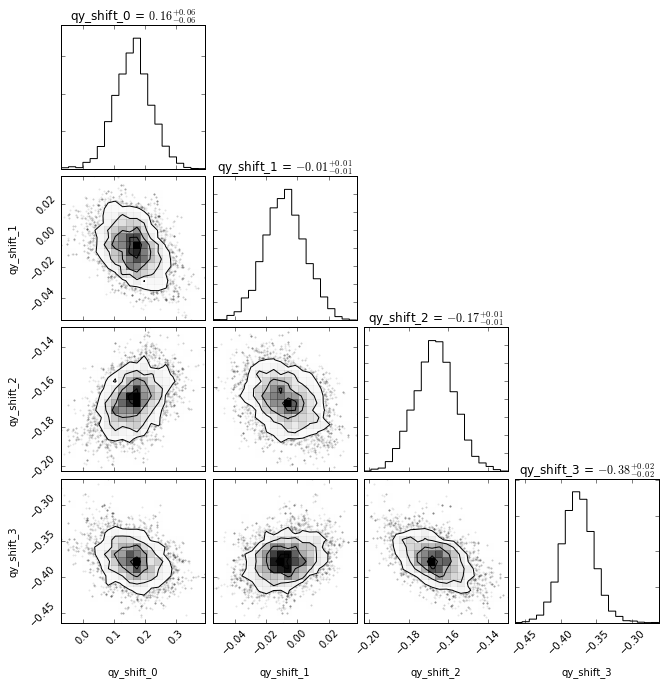

In [61]:
corner.corner(samples, show_titles=True, labels=names)
plt.show()

(0, 11)

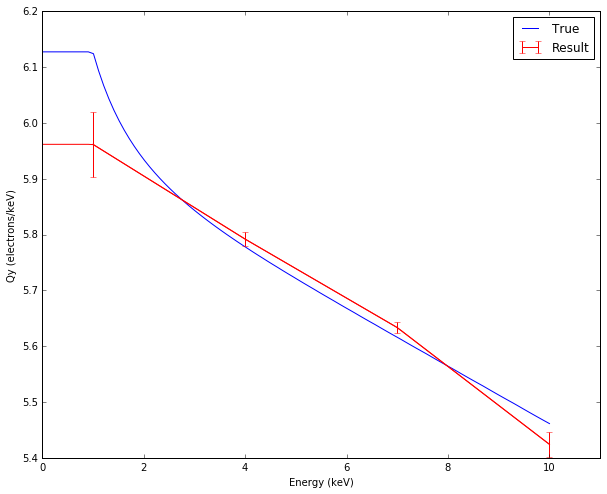

In [75]:
plt.figure(figsize=(10, 8))
plot_true_qy()
plot_qy(fit_result, errors=sigma, label='Result', color='red')
plt.legend(loc='upper right')
plt.xlim(0, 11)

As we hoped, we get a good fit above 2-3 keV, and have poor sensitivity at lower energies. To decrease the errors you can try to:
  * increase the number of PDF bins and PDF samples,
  * increase the number of anchor models for each line segment ponit
  * add more line segment points, or use a more functional model 